In [167]:
import numpy, matplotlib, pickle

#matplotlib.use ('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [168]:
with open ('results_AILVOICH_2D_readTimeDiseaseProb.p', 'rb') as f:
    results = pickle.load (f)
f.close ()

In [169]:
plotPath = 'plots/'

queuetypes = ['preemptive', 'nonPreemptive']
diseasenames = ['LVO', 'ICH']
colors = {'sim_LVO':'lightcoral', 'sim_ICH':'lightskyblue', 'theory_LVO':'red', 'theory_ICH':'blue'}

In [170]:
################################
## Define constants
################################
diseaseProbICH = (735+1368)/(3716+6238) # 10.2214/AJR.24.31639, Table 1
readTimeICH    = 24.3  # +/- 21.3, 10.2214/AJR.24.31639, Table 5
readTimeNDNCCT = 30.24 # Assuming same as readTimeNDNCCT

diseaseProbLVO = (48+47)/(439+321) # 10.3389/fneur.2023.1179250, p.3
readTimeLVO    = 32.67  # +/- 31.71, 10.3389/fneur.2023.1179250, Table 1
readTimeNDCTA  = 30.24  # +/- 29.57, 10.3389/fneur.2023.1179250, Table 1

sameReadTime = 30

AILVOSe, AILVOSp = 0.9236, 0.9143
AIICHSe, AIICHSp = 0.9362, 0.9343

## +------------------------
## | For AI-LVO only
## +------------------------
## 2. same read-time, traffic, AI-LVO threshold
##    vary diseaseProbs: 0.0 - 0.4
diseaseProbICHs = numpy.linspace (0.0, 0.4, 60)
diseaseProbLVOs = numpy.linspace (0.0, 0.4, 60)
## 3. same disease probs, traffic, AI-LVO threshold
##    vary read times: 1 - 60
readTimeICHs = numpy.linspace (1, 60, 60)
readTimeLVOs = numpy.linspace (1, 60, 60)

## Disease Prob

traffic = 0.8

sameReadTime = 30

groupProbNCCT = 0.7

groupProbCTA  = 0.3

AILVOSe = 0.9236

AILVOSp = 0.9143

nRad = 1

In [171]:
def plot_top (axis, data, diseasename, title, nxticks=8, nyticks=4):

    ## Plot a slice at the default y value along the x-axis
    ## For readtime   : top plot is along readtime LVO at default readtime ICH = 30 min
    ## For diseaseprob: top plot is along diseaseProb LVO at default diseaseProb ICH = 0.211

    xvalues = numpy.array (data['LVO']['timeSaved']['xvalue'].T[0])
    xIdx = numpy.argmin (numpy.abs (xvalues - diseaseProbICH))

    yvalues = numpy.abs (data[diseasename]['timeSaved']['sim']['mean']).T[xIdx]
    lower95 = numpy.abs (data[diseasename]['timeSaved']['sim']['upper95']).T[xIdx]
    upper95 = numpy.abs (data[diseasename]['timeSaved']['sim']['lower95']).T[xIdx]
    label  = 'sim (95% CI)'
    axis.plot (xvalues, yvalues, color=colors['sim_'+diseasename], linestyle='-',
                alpha=0.9, linewidth=2, label=label)
    axis.fill_between (xvalues, lower95, upper95, color=colors['sim_'+diseasename], alpha=0.2)

    label  = 'theory'
    axis.plot (xvalues, numpy.abs (data[diseasename]['timeSaved']['theory']['delta']).T[xIdx],
               color=colors['theory_'+diseasename],
               linestyle='--', alpha=0.7, linewidth=2, label=label)

    # Format x-axis
    xranges = [xvalues[0], xvalues[-1]]
    xticks = numpy.linspace (xranges[0], xranges[1], nxticks)
    axis.set_xticks (xticks)
    axis.set_xlim (xranges)
    axis.xaxis.set_ticklabels ([])
    for xtick in axis.get_xticks():
        axis.axvline (x=xtick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)   
    # Format y-axis
    yranges = [max (0, numpy.nanmin (lower95)-5), numpy.nanmax (upper95)+5]
    yticks = numpy.linspace (yranges[0], yranges[1], nyticks)
    yticklabels = [int (y) for y in yticks]
    axis.set_yticks (yticks)
    axis.set_ylim (yranges)
    ylab = 'Time\nsaved\n[min]' 
    axis.set_ylabel (ylab, fontsize=9)
    axis.set_yticklabels (yticklabels, fontsize=8)
    for ytick in axis.get_yticks():
        axis.axhline (y=ytick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)
    # Format legend
    axis.set_title (title, fontsize=10)
    loc = 1 if diseasename == 'LVO' else 2
    ncol = 2 if diseasename == 'LVO' else 1
    axis.legend (loc=loc, ncol=ncol, prop={'size':5})
    
    return axis

In [172]:
def plot_left (axis, data, diseasename, nxticks=8, nyticks=4):

    ## Plot a slice at the default x value along the y-axis
    ## For readtime   : left plot is along readtime ICH at default readtime LVO = 30 min
    ## For diseaseprob: left plot is along diseaseProb ICH at default diseaseProb LVO = 0.125

    yvalues = numpy.array (data['ICH']['timeSaved']['xvalue'].T[0])
    yIdx = numpy.argmin (numpy.abs (yvalues - diseaseProbLVO))

    xvalues = numpy.abs (data[diseasename]['timeSaved']['sim']['mean'])[yIdx]
    lower95 = numpy.abs (data[diseasename]['timeSaved']['sim']['upper95'])[yIdx]
    upper95 = numpy.abs (data[diseasename]['timeSaved']['sim']['lower95'])[yIdx]
    label  = 'sim (95% CI)'
    axis.plot (xvalues, yvalues, color=colors['sim_'+diseasename], linestyle='-',
                alpha=0.9, linewidth=2, label=label)
    axis.fill_betweenx (yvalues, lower95, upper95, color=colors['sim_'+diseasename], alpha=0.2)

    axis.plot (numpy.abs (data[diseasename]['timeSaved']['theory']['delta'])[yIdx],
               yvalues, color=colors['theory_'+diseasename],
               linestyle='--', alpha=0.7, linewidth=2)

    # Format y-axis
    yranges = [yvalues[0], yvalues[-1]]
    yticks = numpy.linspace (yranges[0], yranges[1], nyticks)
    yticklabels = [round (y, 2) for y in yticks]
    axis.set_yticks (yticks)
    axis.set_ylim (yranges)
    #axis.yaxis.set_ticklabels ([])
    axis.set_ylabel ('ICH disease prevalence', fontsize=9)
    axis.yaxis.set_ticks (yticks)
    axis.yaxis.set_ticklabels (yticklabels, fontsize=8)    
    for ytick in axis.get_yticks():
        axis.axhline (y=ytick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)   
    # Format x-axis
    xranges = [max (0, numpy.nanmin (lower95)-5), numpy.nanmax (upper95)+5]
    xticks = numpy.linspace (xranges[0], xranges[1], nxticks)
    xticklabels = [int (x) for x in xticks]
    axis.set_xticks (xticks)
    axis.set_xlim (xranges)
    xlab = 'Time-saved\n[min]' 
    axis.set_xlabel (xlab, fontsize=9)
    axis.set_xticklabels (xticklabels, fontsize=8, rotation=15)
    axis.invert_xaxis()
    for xtick in axis.get_xticks():
        axis.axvline (x=xtick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)

    return axis

In [173]:
def format_axis (axis, xlim, ylim, xlabel, nxticks, nyticks):

    # Format x-axis
    xticks = numpy.linspace (xlim[0], xlim[-1], nxticks)     
    xticklabels = ['{0:.2f}'.format (x) for x in xticks]
    axis.set_xticks (xticks)
    axis.set_xlim (xlim)
    axis.set_xlabel (xlabel, fontsize=9)
    axis.set_xticklabels (xticklabels, fontsize=8)
    for xtick in axis.get_xticks():
        axis.axvline (x=xtick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)
    # Format y-axis
    ylim = [ylim[0], ylim[-1]]
    yticks = numpy.linspace (ylim[0], ylim[1], nyticks) 
    axis.set_ylim (ylim)
    axis.yaxis.set_ticks (yticks)
    axis.yaxis.set_ticklabels ([])
    for ytick in axis.get_yticks():
        axis.axhline (y=ytick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)
    return xticks, yticks

def plot_map (axis, data, diseasename, cmap, nxticks=8, nyticks=4):

    ## Plot 2D map
    yvalues = numpy.array (data['ICH']['timeSaved']['xvalue'].T[0])
    xvalues = numpy.array (data['LVO']['timeSaved']['xvalue'].T[0])
    zvalues = numpy.abs (data[diseasename]['timeSaved']['sim']['mean']).T
    #grid = numpy.meshgrid (xvalues, yvalues)

    xranges = (min (xvalues), max (xvalues))
    yranges = (min (yvalues), max (yvalues))
    xlabel = 'LVO disease prevalence'
    
    zranges = [numpy.nanmin (zvalues), numpy.nanmax (zvalues)]
    contourf = axis.contourf (xvalues, yvalues, zvalues, levels=200, cmap=cmap, extend='both',
                              vmin=zranges[0], vmax=zranges[1])

    yIdx = numpy.argmin (numpy.abs (yvalues - diseaseProbICH))
    axis.axhline (yvalues[yIdx], color='black', alpha=0.7, linestyle='--', linewidth=1)
    xIdx = numpy.argmin (numpy.abs (xvalues - diseaseProbLVO))
    axis.axvline (xvalues[xIdx], color='black', alpha=0.7, linestyle='--', linewidth=1)

    # Format axis & print text
    xticks, yticks = format_axis (axis, xranges, yranges, xlabel, nxticks, nyticks)
    return zranges

def plot_colorbar (axis, diseasename, zranges, cmap, zbins=20):

    zlabel  = 'Time-saved' 
    zlabel += ' for {0} patients'.format (diseasename)

    gradients = numpy.linspace (zranges[0], zranges[1], zbins)
    norm = matplotlib.colors.BoundaryNorm (gradients, cmap.N)
    zticks = numpy.linspace (zranges[0], zranges[1], 7)
    cb = matplotlib.colorbar.ColorbarBase (axis, norm=norm, ticks=zticks, cmap=cmap,
                                           spacing='uniform', orientation='vertical')
    zticklabels = ['{0:.0f}'.format (t) for t in zticks]
    cb.ax.set_yticklabels (zticklabels)
    cb.ax.tick_params (labelsize=8)
    cb.set_label (zlabel, fontsize=9)

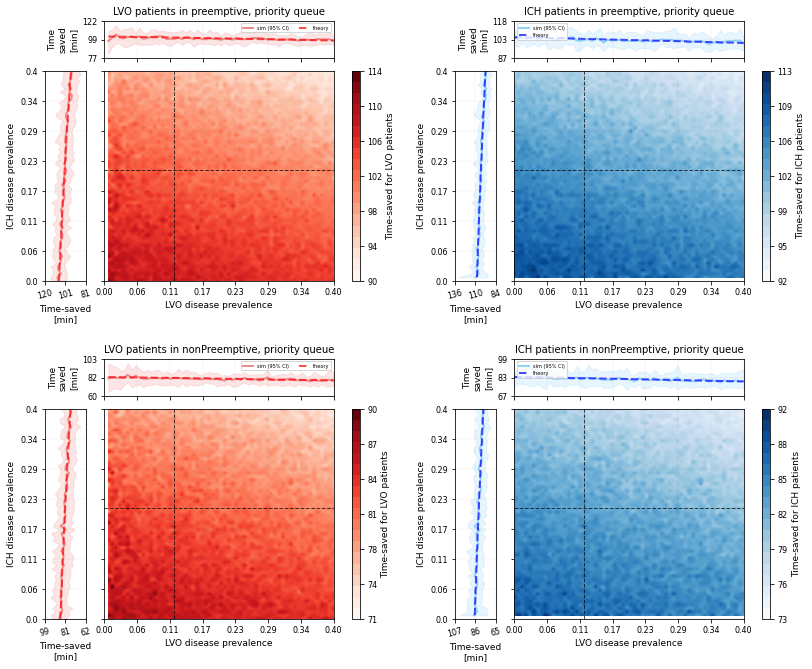

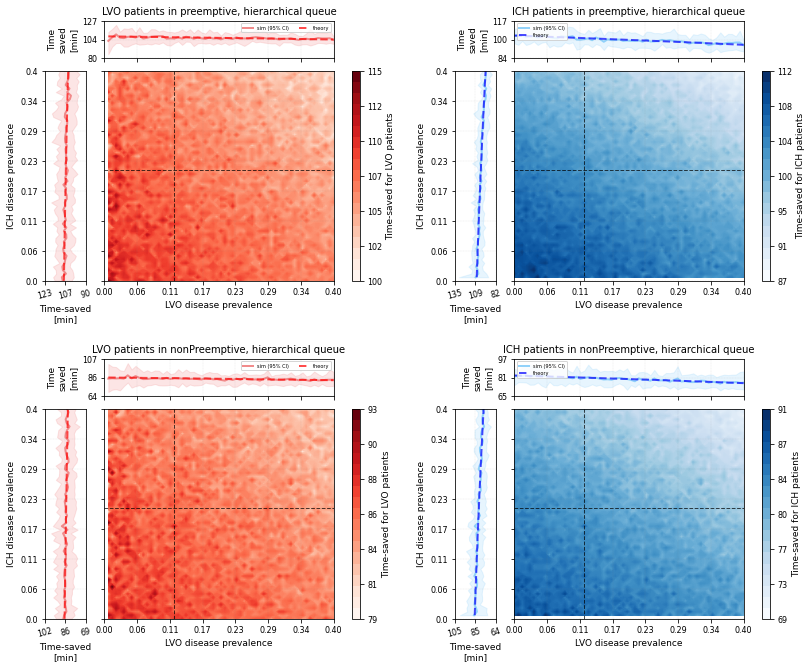

In [174]:
def plot_diseaseProb (prioritytype='priority'):

    figsize=(13, 11)
    h  = plt.figure (figsize=figsize)
    gs = gridspec.GridSpec (2, 2, wspace=0.3, hspace=0.3)
    #gs.update (bottom=0.2)

    gindex = 0
    for queuetype in queuetypes:

        data = results['diseaseProb'][queuetype][prioritytype]
        for diseasename in results['diseaseProb'][queuetype][prioritytype].keys():

            cmapname = 'Reds' if diseasename == 'LVO' else 'Blues'
            cmap = plt.get_cmap (cmapname)

            # Divide the plot
            subgs = gs[gindex].subgridspec(2, 3, width_ratios=[5, 28, 1], height_ratios=[5, 28], wspace=0.2, hspace=0.1)

            # 1. top
            axis = h.add_subplot (subgs[1])
            title = '{0} patients in {1}, {2} queue'.format (diseasename, queuetype, prioritytype)
            plot_top (axis, data, diseasename, title, nxticks=8, nyticks=3)

            # 2. left
            axis = h.add_subplot (subgs[3])
            plot_left (axis, data, diseasename, nxticks=3, nyticks=8)

            # 3. map
            axis = h.add_subplot (subgs[4])
            zranges = plot_map (axis, data, diseasename, cmap, nxticks=8, nyticks=8)
            axis = h.add_subplot (subgs[5])
            plot_colorbar (axis, diseasename, zranges, cmap, zbins=20)
            
            gindex += 1

    plt.show()
    h.savefig (plotPath + 'AILVOICH_2D_diseaseProb_{0}.png'.format (prioritytype), dpi=600)
    plt.close('all')    

plot_diseaseProb (prioritytype='priority')
plot_diseaseProb (prioritytype='hierarchical')

Points:
1. mean values from theory matches that of simulation
2. Time-savings among LVO patients do not change by disease prevalence of LVO and ICH
3. More time delay for ICH patients as a function of LVO disease prevalence
4. More time-saving for LVO and less time delay for ICH in preemptive than in non-preemptive.
5. With 2 diseases and 1 AI triaging LVO, priority and hierarchical queues return same outputs

## ReadTime

diseaseProbICH = 0.211 from 10.2214/AJR.24.31639, Table 1

diseaseProbLVO = 0.125 from 10.3389/fneur.2023.1179250, p.3

groupProbNCCT = 0.7

groupProbCTA  = 0.3

traffic = 0.8

AILVOSe = 0.9236

AILVOSp = 0.9143

nRad = 1

In [175]:
def plot_top (axis, data, diseasename, title, nxticks=8, nyticks=4):

    ## Plot a slice at the default y value along the x-axis
    ## For readtime   : top plot is along readtime LVO at default readtime ICH = 30 min
    ## For diseaseprob: top plot is along diseaseProb LVO at default diseaseProb ICH = 0.211

    xvalues = numpy.array (data['LVO']['timeSaved']['xvalue'].T[0])
    xIdx = numpy.argmin (numpy.abs (xvalues - sameReadTime))

    yvalues = numpy.abs (data[diseasename]['timeSaved']['sim']['mean']).T[xIdx]
    lower95 = numpy.abs (data[diseasename]['timeSaved']['sim']['upper95']).T[xIdx]
    upper95 = numpy.abs (data[diseasename]['timeSaved']['sim']['lower95']).T[xIdx]
    label  = 'sim (95% CI)'
    axis.plot (xvalues, yvalues, color=colors['sim_'+diseasename], linestyle='-',
                alpha=0.9, linewidth=2, label=label)
    axis.fill_between (xvalues, lower95, upper95, color=colors['sim_'+diseasename], alpha=0.2)

    label  = 'theory'
    theory = numpy.abs (data[diseasename]['timeSaved']['theory']['delta']).T[xIdx]
    axis.plot (xvalues, theory, color=colors['theory_'+diseasename],
               linestyle='--', alpha=0.7, linewidth=2, label=label)

    # Format x-axis
    xranges = [0, 60]
    xticks = numpy.linspace (xranges[0], xranges[1], nxticks)
    axis.set_xticks (xticks)
    axis.set_xlim (xranges)
    axis.xaxis.set_ticklabels ([])
    for xtick in axis.get_xticks():
        axis.axvline (x=xtick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)   
    # Format y-axis
    yranges = [max (0, max (numpy.nanmin (lower95)-5, numpy.nanmin (theory)-5)),
               max (numpy.nanmax (upper95)+5, numpy.nanmax (theory)+5)]
    yticks = numpy.linspace (yranges[0], yranges[1], nyticks)
    yticklabels = [int (y) for y in yticks]
    axis.set_yticks (yticks)
    axis.set_ylim (yranges)
    ylab = 'Time\nsaved\n[min]'
    axis.set_ylabel (ylab, fontsize=9)
    axis.set_yticklabels (yticklabels, fontsize=8)
    for ytick in axis.get_yticks():
        axis.axhline (y=ytick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)
    # Format legend
    axis.set_title (title, fontsize=10)
    loc = 1 if diseasename == 'LVO' else 2
    ncol = 2 if diseasename == 'LVO' else 1
    axis.legend (loc=loc, ncol=ncol, prop={'size':5})
    
    return axis

In [176]:
def plot_left (axis, data, diseasename, nxticks=8, nyticks=4):

    ## Plot a slice at the default x value along the y-axis
    ## For readtime   : left plot is along readtime ICH at default readtime LVO = 30 min
    ## For diseaseprob: left plot is along diseaseProb ICH at default diseaseProb LVO = 0.125

    yvalues = numpy.array (data['ICH']['timeSaved']['xvalue'].T[0])
    yIdx = numpy.argmin (numpy.abs (yvalues - sameReadTime))

    xvalues = numpy.abs (data[diseasename]['timeSaved']['sim']['mean'])[yIdx]
    lower95 = numpy.abs (data[diseasename]['timeSaved']['sim']['upper95'])[yIdx]
    upper95 = numpy.abs (data[diseasename]['timeSaved']['sim']['lower95'])[yIdx]
    label  = 'sim (95% CI)'
    axis.plot (xvalues, yvalues, color=colors['sim_'+diseasename], linestyle='-',
                alpha=0.9, linewidth=2, label=label)
    axis.fill_betweenx (yvalues, lower95, upper95, color=colors['sim_'+diseasename], alpha=0.2)

    theory = numpy.abs (data[diseasename]['timeSaved']['theory']['delta'])[yIdx]
    axis.plot (theory, 
               yvalues, color=colors['theory_'+diseasename],
               linestyle='--', alpha=0.7, linewidth=2)

    # Format y-axis
    yranges = [0, 60]
    yticks = numpy.linspace (yranges[0], yranges[1], nyticks)
    yticklabels = [int (y) for y in yticks]
    axis.set_yticks (yticks)
    axis.set_ylim (yranges)
    #axis.yaxis.set_ticklabels ([])
    axis.set_ylabel ('ICH reading time [min]', fontsize=9)
    axis.yaxis.set_ticks (yticks)
    axis.yaxis.set_ticklabels (yticklabels, fontsize=8)    
    for ytick in axis.get_yticks():
        axis.axhline (y=ytick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)   
    # Format x-axis
    xranges = [max (0, min (numpy.nanmin (lower95)-5, numpy.nanmin (theory)-5)),
               max (numpy.nanmax (upper95)+5, numpy.nanmax (theory)+5)]    
    xticks = numpy.linspace (xranges[0], xranges[1], nxticks)
    xticklabels = [int (x) for x in xticks]
    axis.set_xticks (xticks)
    axis.set_xlim (xranges)
    xlab = 'Time-saved\n[min]'
    axis.set_xlabel (xlab, fontsize=9)
    axis.set_xticklabels (xticklabels, fontsize=8, rotation=15)
    axis.invert_xaxis()
    for xtick in axis.get_xticks():
        axis.axvline (x=xtick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)

    return axis

In [177]:
def format_axis (axis, xlim, ylim, xlabel, nxticks, nyticks):

    # Format x-axis
    xticks = numpy.linspace (xlim[0], xlim[-1], nxticks)     
    xticklabels = ['{0:.0f}'.format (x) for x in xticks]
    axis.set_xticks (xticks)
    axis.set_xlim (xlim)
    axis.set_xlabel (xlabel, fontsize=9)
    axis.set_xticklabels (xticklabels, fontsize=8)
    for xtick in axis.get_xticks():
        axis.axvline (x=xtick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)
    # Format y-axis
    ylim = [ylim[0], ylim[-1]]
    yticks = numpy.linspace (ylim[0], ylim[1], nyticks) 
    axis.set_ylim (ylim)
    axis.yaxis.set_ticks (yticks)
    axis.yaxis.set_ticklabels ([])
    for ytick in axis.get_yticks():
        axis.axhline (y=ytick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)
    return xticks, yticks

def plot_map (axis, data, diseasename, cmap, nxticks=8, nyticks=4):

    ## Plot 2D map
    yvalues = numpy.array (data['ICH']['timeSaved']['xvalue'].T[0])
    xvalues = numpy.array (data['LVO']['timeSaved']['xvalue'].T[0])
    zvalues = numpy.abs (data[diseasename]['timeSaved']['sim']['mean']).T

    xranges = [0, 60]
    yranges = [0, 60]
    xlabel = 'LVO reading time [min]'
    
    zranges = [numpy.nanmin (zvalues), numpy.nanmax (zvalues)]
    contourf = axis.contourf (xvalues, yvalues, zvalues, levels=200, cmap=cmap, extend='both',
                              vmin=zranges[0], vmax=zranges[1])

    yIdx = numpy.argmin (numpy.abs (yvalues - sameReadTime))
    axis.axhline (yvalues[yIdx], color='black', alpha=0.7, linestyle='--', linewidth=1)
    xIdx = numpy.argmin (numpy.abs (xvalues - sameReadTime))
    axis.axvline (xvalues[xIdx], color='black', alpha=0.7, linestyle='--', linewidth=1)

    # Format axis & print text
    xticks, yticks = format_axis (axis, xranges, yranges, xlabel, nxticks, nyticks)
    return zranges

def plot_colorbar (axis, diseasename, zranges, cmap, zbins=20):

    zlabel  = 'Time-saved' 
    zlabel += ' for {0} patients'.format (diseasename)

    gradients = numpy.linspace (zranges[0], zranges[1], zbins)
    norm = matplotlib.colors.BoundaryNorm (gradients, cmap.N)
    zticks = numpy.linspace (zranges[0], zranges[1], 7)
    cb = matplotlib.colorbar.ColorbarBase (axis, norm=norm, ticks=zticks, cmap=cmap,
                                           spacing='uniform', orientation='vertical')
    zticklabels = ['{0:.0f}'.format (t) for t in zticks]
    cb.ax.set_yticklabels (zticklabels)
    cb.ax.tick_params (labelsize=8)
    cb.set_label (zlabel, fontsize=9)

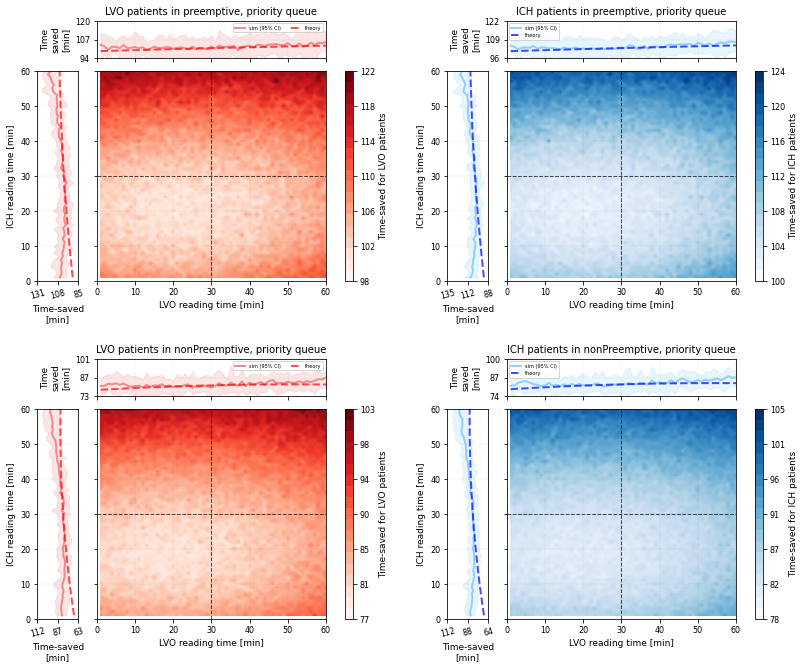

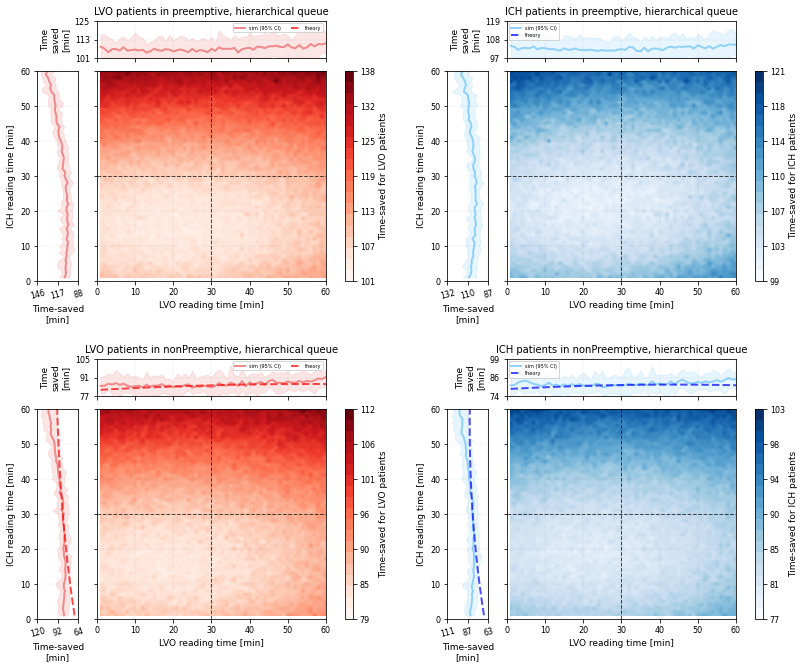

In [178]:
def plot_readTime (prioritytype='priority'):

    figsize=(13, 11)
    h  = plt.figure (figsize=figsize)
    gs = gridspec.GridSpec (2, 2, wspace=0.3, hspace=0.3)
    #gs.update (bottom=0.2)

    gindex = 0
    for queuetype in queuetypes:

        data = results['readTime'][queuetype][prioritytype]
        for diseasename in results['readTime'][queuetype][prioritytype].keys():

            cmapname = 'Reds' if diseasename == 'LVO' else 'Blues'
            cmap = plt.get_cmap (cmapname)

            # Divide the plot
            subgs = gs[gindex].subgridspec(2, 3, width_ratios=[5, 28, 1], height_ratios=[5, 28], wspace=0.2, hspace=0.1)

            # 1. top
            axis = h.add_subplot (subgs[1])
            title = '{0} patients in {1}, {2} queue'.format (diseasename, queuetype, prioritytype)
            plot_top (axis, data, diseasename, title, nxticks=7, nyticks=3)

            # 2. left
            axis = h.add_subplot (subgs[3])
            plot_left (axis, data, diseasename, nxticks=3, nyticks=7)

            # 3. map
            axis = h.add_subplot (subgs[4])
            zranges = plot_map (axis, data, diseasename, cmap, nxticks=7, nyticks=7)
            axis = h.add_subplot (subgs[5])
            plot_colorbar (axis, diseasename, zranges, cmap, zbins=20)
            
            gindex += 1

    plt.show()
    h.savefig (plotPath + 'AILVOICH_2D_readTime_{0}.png'.format (prioritytype), dpi=600)
    plt.close('all')    

plot_readTime (prioritytype='priority')
plot_readTime (prioritytype='hierarchical')

## AI Thresholds

diseaseProbICH = 0.211 from 10.2214/AJR.24.31639, Table 1

diseaseProbLVO = 0.125 from 10.3389/fneur.2023.1179250, p.3

groupProbNCCT = 0.7

groupProbCTA  = 0.3

traffic = 0.8

all read time = 30

nRad = 1

In [179]:
with open ('results_AILVOICH_2D_AIs.p', 'rb') as f:
    results = pickle.load (f)
f.close ()

In [180]:
sameLVOFPF = 1 - AILVOSp
sameICHFPF = 1 - AIICHSp

In [181]:
def plot_top (axis, data, diseasename, title, nxticks=8, nyticks=4):

    ## Plot a slice at the default y value along the x-axis
    ## For readtime   : top plot is along readtime LVO at default readtime ICH = 30 min
    ## For diseaseprob: top plot is along diseaseProb LVO at default diseaseProb ICH = 0.211

    xvalues = numpy.array (data['LVO']['timeSaved']['xvalue'].T[0])
    xIdx = numpy.argmin (numpy.abs (xvalues - sameLVOFPF))

    yvalues = -1* (data[diseasename]['timeSaved']['sim']['mean']).T[xIdx]
    lower95 = -1* (data[diseasename]['timeSaved']['sim']['upper95']).T[xIdx]
    upper95 = -1* (data[diseasename]['timeSaved']['sim']['lower95']).T[xIdx]
    label  = 'sim (95% CI)'
    axis.plot (xvalues, yvalues, color=colors['sim_'+diseasename], linestyle='-',
                alpha=0.9, linewidth=2, label=label)
    axis.fill_between (xvalues, lower95, upper95, color=colors['sim_'+diseasename], alpha=0.2)

    label  = 'theory'
    theory = -1* (data[diseasename]['timeSaved']['theory']['delta']).T[xIdx]
    axis.plot (xvalues, theory, color=colors['theory_'+diseasename],
               linestyle='--', alpha=0.7, linewidth=2, label=label)

    # Format x-axis
    xranges = [0, 1]
    xticks = numpy.linspace (xranges[0], xranges[1], nxticks)
    axis.set_xticks (xticks)
    axis.set_xlim (xranges)
    axis.xaxis.set_ticklabels ([])
    for xtick in axis.get_xticks():
        axis.axvline (x=xtick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)   
    # Format y-axis
    yranges = [min (numpy.nanmin (lower95)-5, numpy.nanmin (theory)-5),
               max (numpy.nanmax (upper95)+5, numpy.nanmax (theory)+5)]
    yticks = numpy.linspace (yranges[0], yranges[1], nyticks)
    yticklabels = [int (y) for y in yticks]
    axis.set_yticks (yticks)
    axis.set_ylim (yranges)
    ylab = 'Time\nsaved\n[min]' 
    axis.set_ylabel (ylab, fontsize=9)
    axis.set_yticklabels (yticklabels, fontsize=8)
    for ytick in axis.get_yticks():
        axis.axhline (y=ytick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)
    # Format legend
    axis.set_title (title, fontsize=10)
    loc = 4 if diseasename == 'LVO' else 3
    ncol = 2 if diseasename == 'LVO' else 1
    axis.legend (loc=loc, ncol=ncol, prop={'size':5})
    
    return axis

In [182]:
def plot_left (axis, data, diseasename, nxticks=8, nyticks=4):

    ## Plot a slice at the default x value along the y-axis
    ## For readtime   : left plot is along readtime ICH at default readtime LVO = 30 min
    ## For diseaseprob: left plot is along diseaseProb ICH at default diseaseProb LVO = 0.125

    yvalues = numpy.array (data['ICH']['timeSaved']['xvalue'].T[0])
    yIdx = numpy.argmin (numpy.abs (yvalues - sameICHFPF))

    xvalues = -1* (data[diseasename]['timeSaved']['sim']['mean'])[yIdx]
    lower95 = -1* (data[diseasename]['timeSaved']['sim']['upper95'])[yIdx]
    upper95 = -1* (data[diseasename]['timeSaved']['sim']['lower95'])[yIdx]
    label  = 'sim (95% CI)'
    axis.plot (xvalues, yvalues, color=colors['sim_'+diseasename], linestyle='-',
                alpha=0.9, linewidth=2, label=label)
    axis.fill_betweenx (yvalues, lower95, upper95, color=colors['sim_'+diseasename], alpha=0.2)

    theory = -1* (data[diseasename]['timeSaved']['theory']['delta'])[yIdx]
    axis.plot (theory, 
               yvalues, color=colors['theory_'+diseasename],
               linestyle='--', alpha=0.7, linewidth=2)

    # Format y-axis
    yranges = [0, 1]
    yticks = numpy.linspace (yranges[0], yranges[1], nyticks)
    yticklabels = ['{0:.2f}'.format (y) for y in yticks]
    axis.set_yticks (yticks)
    axis.set_ylim (yranges)
    axis.set_ylabel ('AI-ICH FPF', fontsize=9)
    axis.yaxis.set_ticklabels (yticklabels, fontsize=8)    
    for ytick in axis.get_yticks():
        axis.axhline (y=ytick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)   
    # Format x-axis
    xranges = [min (numpy.nanmin (lower95)-5, numpy.nanmin (theory)-5),
               max (numpy.nanmax (upper95)+5, numpy.nanmax (theory)+5)]    
    xticks = numpy.linspace (xranges[0], xranges[1], nxticks)
    xticklabels = [int (x) for x in xticks]
    axis.set_xticks (xticks)
    axis.set_xlim (xranges)
    xlab = 'Time-saved\n[min]' 
    axis.set_xlabel (xlab, fontsize=9)
    axis.set_xticklabels (xticklabels, fontsize=8, rotation=15)
    axis.invert_xaxis()
    for xtick in axis.get_xticks():
        axis.axvline (x=xtick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)

    return axis

In [183]:
def format_axis (axis, xlim, ylim, xlabel, nxticks, nyticks):

    # Format x-axis
    xticks = numpy.linspace (xlim[0], xlim[-1], nxticks)     
    xticklabels = ['{0:.2f}'.format (x) for x in xticks]
    axis.set_xticks (xticks)
    axis.set_xlim (xlim)
    axis.set_xlabel (xlabel, fontsize=9)
    axis.set_xticklabels (xticklabels, fontsize=8)
    for xtick in axis.get_xticks():
        axis.axvline (x=xtick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)
    # Format y-axis
    ylim = [ylim[0], ylim[-1]]
    yticks = numpy.linspace (ylim[0], ylim[1], nyticks) 
    axis.set_ylim (ylim)
    axis.yaxis.set_ticks (yticks)
    axis.yaxis.set_ticklabels ([])
    for ytick in axis.get_yticks():
        axis.axhline (y=ytick, color='gray', alpha=0.3, linestyle='--', linewidth=0.3)
    return xticks, yticks

def plot_map (axis, data, diseasename, cmap, nxticks=8, nyticks=4):

    ## Plot 2D map
    yvalues = numpy.array (data['ICH']['timeSaved']['xvalue'].T[0])
    xvalues = numpy.array (data['LVO']['timeSaved']['xvalue'].T[0])
    zvalues = -1* (data[diseasename]['timeSaved']['sim']['mean']).T

    xranges = [0, 1]
    yranges = [0, 1]
    xlabel = 'AI-LVO FPF'
    
    zranges = [numpy.nanmin (zvalues), numpy.nanmax (zvalues)]
    contourf = axis.contourf (xvalues, yvalues, zvalues, levels=200, cmap=cmap, extend='both',
                              vmin=zranges[0], vmax=zranges[1])

    yIdx = numpy.argmin (numpy.abs (yvalues - sameICHFPF))
    axis.axhline (yvalues[yIdx], color='black', alpha=0.7, linestyle='--', linewidth=1)
    xIdx = numpy.argmin (numpy.abs (xvalues - sameLVOFPF))
    axis.axvline (xvalues[xIdx], color='black', alpha=0.7, linestyle='--', linewidth=1)

    # Format axis & print text
    xticks, yticks = format_axis (axis, xranges, yranges, xlabel, nxticks, nyticks)
    return zranges

def plot_colorbar (axis, diseasename, zranges, cmap, zbins=20):

    zlabel  = 'Time-saved' 
    zlabel += ' for {0} patients'.format (diseasename)

    gradients = numpy.linspace (zranges[0], zranges[1], zbins)
    norm = matplotlib.colors.BoundaryNorm (gradients, cmap.N)
    zticks = numpy.linspace (zranges[0], zranges[1], 7)
    cb = matplotlib.colorbar.ColorbarBase (axis, norm=norm, ticks=zticks, cmap=cmap,
                                           spacing='uniform', orientation='vertical')
    zticklabels = ['{0:.0f}'.format (t) for t in zticks]
    cb.ax.set_yticklabels (zticklabels)
    cb.ax.tick_params (labelsize=8)
    cb.set_label (zlabel, fontsize=9)

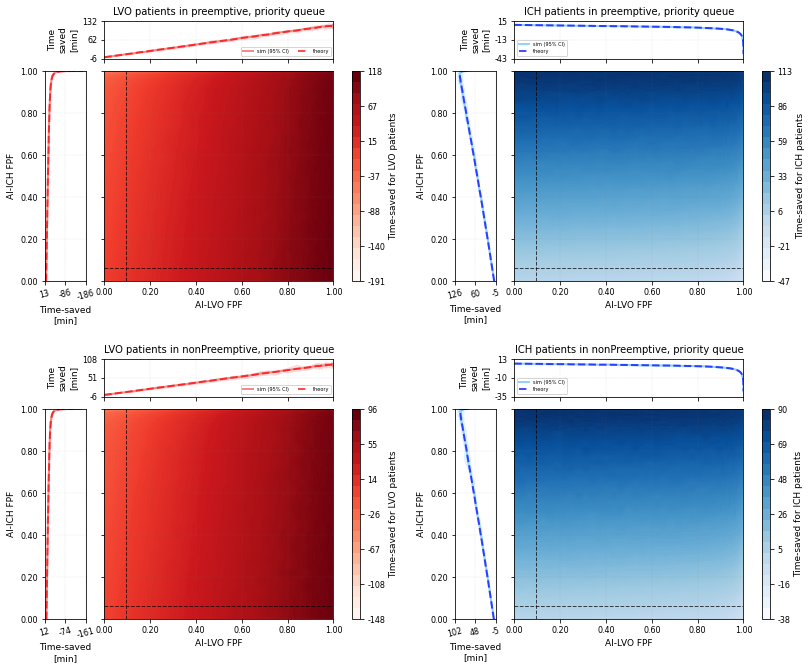

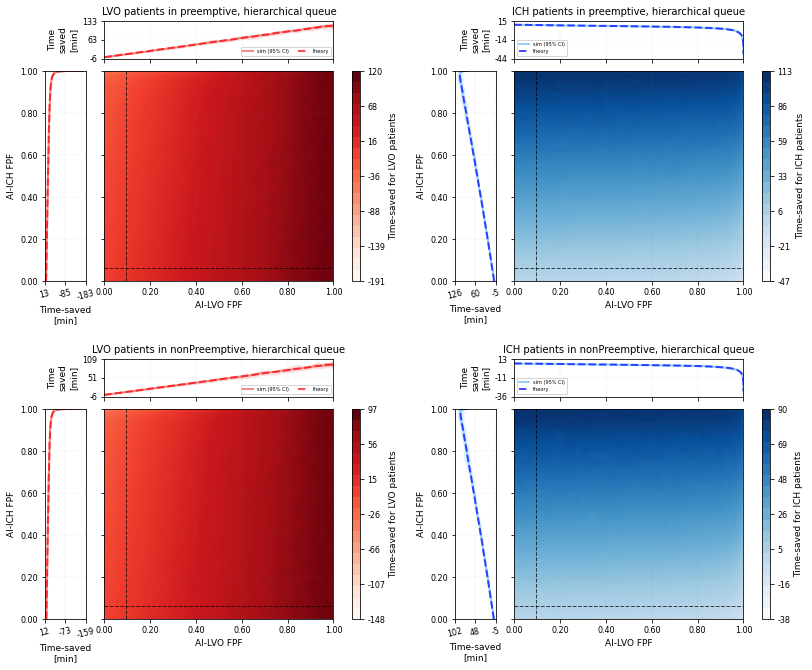

In [184]:
def plot_AI (prioritytype='priority'):

    figsize=(13, 11)
    h  = plt.figure (figsize=figsize)
    gs = gridspec.GridSpec (2, 2, wspace=0.3, hspace=0.3)
    #gs.update (bottom=0.2)

    gindex = 0
    for queuetype in queuetypes:

        data = results['AI'][queuetype][prioritytype]
        for diseasename in results['AI'][queuetype][prioritytype].keys():

            cmapname = 'Reds' if diseasename == 'LVO' else 'Blues'
            cmap = plt.get_cmap (cmapname)

            # Divide the plot
            subgs = gs[gindex].subgridspec(2, 3, width_ratios=[5, 28, 1], height_ratios=[5, 28], wspace=0.2, hspace=0.1)

            # 1. top
            axis = h.add_subplot (subgs[1])
            title = '{0} patients in {1}, {2} queue'.format (diseasename, queuetype, prioritytype)
            plot_top (axis, data, diseasename, title, nxticks=6, nyticks=3)

            # 2. left
            axis = h.add_subplot (subgs[3])
            plot_left (axis, data, diseasename, nxticks=3, nyticks=6)

            # 3. map
            axis = h.add_subplot (subgs[4])
            zranges = plot_map (axis, data, diseasename, cmap, nxticks=6, nyticks=6)
            axis = h.add_subplot (subgs[5])
            plot_colorbar (axis, diseasename, zranges, cmap, zbins=20)
            
            gindex += 1

    plt.show()
    h.savefig (plotPath + 'AILVOICH_2D_AIs_{0}.png'.format (prioritytype), dpi=600)
    plt.close('all')    

plot_AI (prioritytype='priority')
plot_AI (prioritytype='hierarchical')